In [1]:
import numpy as np
import statsmodels.api as sm
import os 
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (5, 4)
import matplotlib as mpl
mpl.rcParams['path.simplify'] = False       # prevents clipping masks on lines
mpl.rcParams['agg.path.chunksize'] = 0      # avoids chunked paths (creates clip paths)
mpl.rcParams['figure.facecolor'] = 'white'  # avoids transparency-related clipping
mpl.rcParams['savefig.transparent'] = False # keep backgrounds opaque
mpl.rcParams['savefig.bbox'] = None      # clean bbox without extra masks
def remove_clipping(ax):
    for artist in ax.get_children():
        if hasattr(artist, "set_clip_on"):
            artist.set_clip_on(False)
        if hasattr(artist, "set_clip_path"):
            artist.set_clip_path(None)

#### AR simulations 


In [2]:
# z-scoring
zs = lambda v: (v-v.mean(0))/v.std(0)


def make_pink_noise(nT, beta=1):
    # beta: power law exponent
    freqs = np.fft.rfftfreq(nT)
    freqs[0] = 1
    spectrum = np.random.randn(len(freqs)) + 1j * np.random.randn(len(freqs))
    spectrum /= freqs ** (beta/2)  # power spectrum follos 1/f^beta, amplitude spectrum follows this
    pink_noise = np.fft.irfft(spectrum, n=nT)
    return pink_noise / np.std(pink_noise)


def make_signal_innov(n_voxs, nT, private_signal_std, corr, beta=0.5):
    """
    n_voxs, nT:    number of voxels and time points
    private_signal_std: signal innovation std (should be the total std)
    corr:          fraction of innovation variance that is shared across voxels
    beta:          fraction of shared variance going to shared_signal_inno
                   (rest 1-beta goes to shared_noise)
    Returns
    -------
    private_signal_innov  : (n_voxs, nT)
    shared_signal_innov    : (nT,)
    shared_noise_innov     : (nT,)
    """

    sigma = private_signal_std  # just renaming

    # Variance allocations
    var_private        = (1.0 - corr) * sigma**2
    var_shared_signal  = corr * beta * sigma**2
    var_shared_noise   = corr * (1.0 - beta) * sigma**2

    # Corresponding stds
    std_private        = np.sqrt(var_private)
    std_shared_signal  = np.sqrt(var_shared_signal)
    std_shared_noise   = np.sqrt(var_shared_noise)

    # Draw components
    private_signal_innov      = np.random.randn(n_voxs, nT) * std_private          # voxel-specific
    shared_signal_innov       = np.random.randn(nT) * std_shared_signal            # shared across voxels & runs
    shared_noise_innov        = np.random.randn(nT) * std_shared_noise             # shared across voxels, per run
    # shared_noise_innov        = np.random.randn(n_voxs, nT) * std_shared_noise     # NOT shared across voxels, per run

    return private_signal_innov, shared_signal_innov, shared_noise_innov

# simulate noise-less AR processes
def make_noiseless_arp(ar_coeff, nT, n_voxs, private_signal_innov):
    time_series = np.zeros((n_voxs, nT))
    time_series[:,0] = private_signal_innov[:,0]
    for t in range(1, nT):
        time_series[:, t] = ar_coeff * time_series[:, t - 1] + private_signal_innov[:,t]
        
    return time_series #(n_voxs, nT)

# simulate noisy AR processes 
def make_additive_noisy_arp(ar_coeff, nT, n_voxs, signal_innov, measurement_noise_std):
    white_noise = np.random.randn(n_voxs, nT) * measurement_noise_std

    time_series = np.zeros((n_voxs, nT))
    time_series[:,0] = signal_innov[:,0]

    for t in range(1, nT):
        time_series[:, t] = ar_coeff * time_series[:, t - 1] + signal_innov[:,t]


    noisy_time_series = time_series + white_noise

    return noisy_time_series


def avg_pop_curvature(X):
    # X: (n_voxs, nT)
    V = X[:, 1:] - X[:, :-1] #(n_series, nT-1)
    norms = np.linalg.norm(V, axis=0) #(nT-1,)
    dots = (V[:, 1:] * V[:, :-1]).sum(0)
    coss = dots / (norms[1:] * norms[:-1])
    angles = np.degrees(np.arccos(coss))
    return angles.mean()  # return mean curvature across series

In [5]:
os.getcwd()

'/Users/oliviaxujiaming/Library/CloudStorage/GoogleDrive-jiamingx1204@gmail.com/Other computers/My MacBook Pro/Language_straightening/scripts'

##### Fig. 1d schematic - noise corruption illustration

In [3]:
w_real = np.array([0.99])
noise, noiseless, noisy = make_noisy_arp(w_real, 80, 1, noise_std=1, measurement_noise_std=3)
plt.figure(figsize=(5, 6))
plt.plot(noiseless.T, color='black', linewidth=1)
plt.title('Noiseless AR(1) Time Series')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.ylim(-20, 20)
plt.tight_layout()
# plt.savefig("noiseless_ar.pdf", format='pdf', bbox_inches='tight')
plt.close()

# Plot noisy signal
plt.figure(figsize=(5, 6))
plt.plot(noise.T, color='grey', alpha=0.5, linewidth=1)
plt.title('Noisy AR(1) Time Series (with Measurement Noise)')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.ylim(-20, 20)
plt.tight_layout()
# plt.savefig("noise_corrupted_ar.pdf", format='pdf', bbox_inches='tight')
plt.close()

plt.figure(figsize=(5, 6))
plt.plot(noiseless.T, color='black', linewidth=1)
plt.plot(noisy.T, color='grey', alpha=0.5, linewidth=1)
plt.title('Noiseless AR(1) Time Series')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.ylim(-20, 20)
plt.tight_layout()
# plt.savefig("noiseless+noise_ar.pdf", format='pdf', bbox_inches='tight')
# plt.close()
# plt.ylim(-8, 5) 
# plt.savefig("AR(1)_fast.pdf", format='pdf', bbox_inches='tight')

NameError: name 'make_noisy_arp' is not defined

##### Model simulation - example 10d population traj PCA (noiseless and noise-corrupted)

Noiseless 10-D population trajectory

In [3]:
from sklearn.decomposition import PCA
w_real = np.array([0.1])
data = make_arp_vec(w_real, 10, 10)  # shape: (100, 10)
curv = avg_pop_curvature(data.T)
pca = PCA(n_components=2)
noiseless_data_2d = pca.fit_transform(data)  # shape: (100, 2)
print(curv)
plt.plot(noiseless_data_2d[:, 0], noiseless_data_2d[:, 1], '-o', markersize=5, color='black')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"10D AR(1) trajectory projected to 2D\nCurvature = {curv:.2f}")
plt.axis('equal')


NameError: name 'make_arp_vec' is not defined

Noisy 10-D population trajectory 

(10, 100)
111.45405906932471


(np.float64(-83.2824431158215),
 np.float64(59.10673093408239),
 np.float64(-25.514621062448967),
 np.float64(35.63261798524568))

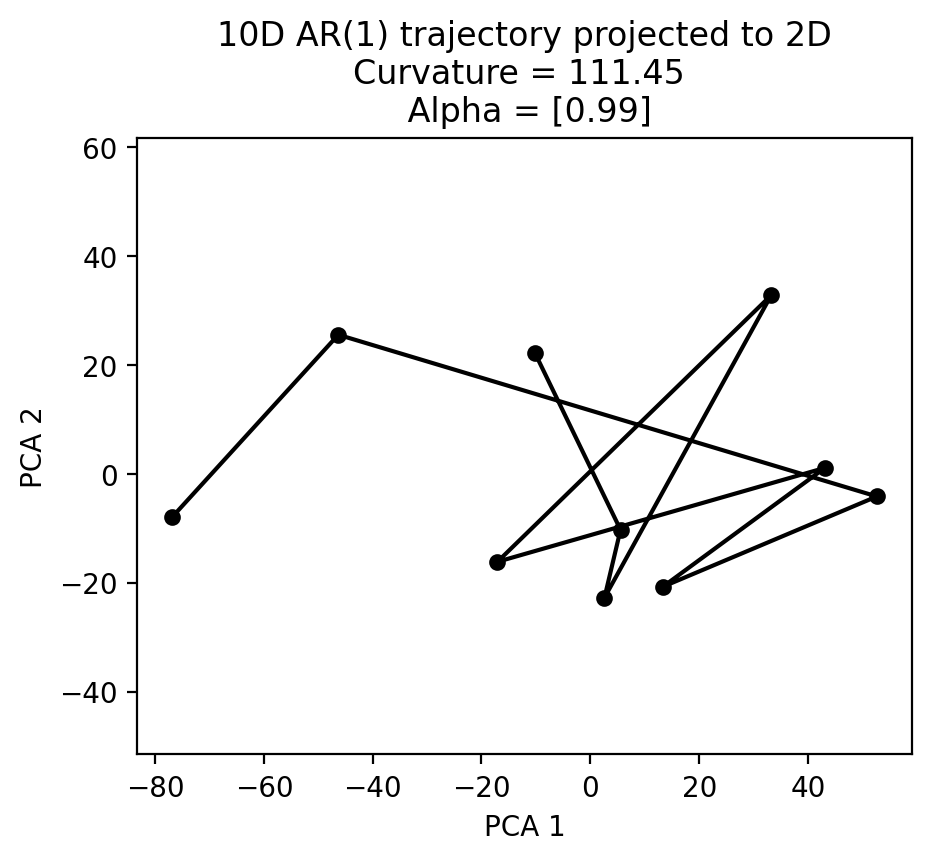

In [ ]:
w_real = np.array([0.99])
data = make_correlated_arp(w_real, nT=100, n_series=10, corr=0, noise_std=1, measurement_noise_std=1)
curv = avg_pop_curvature(data) # need (n_series, nT)
print(data.shape)
print(curv)
pca = PCA(n_components=2)
noisy_data_2d = pca.fit_transform(data)  # shape: (100, 2)

plt.plot(noisy_data_2d[:, 0], noisy_data_2d[:, 1], '-o', markersize=5, color = "black")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"10D AR(1) trajectory projected to 2D\nCurvature = {curv:.2f} \n Alpha = {w_real}")
plt.axis('equal')



Plotting with specific format (pdf)

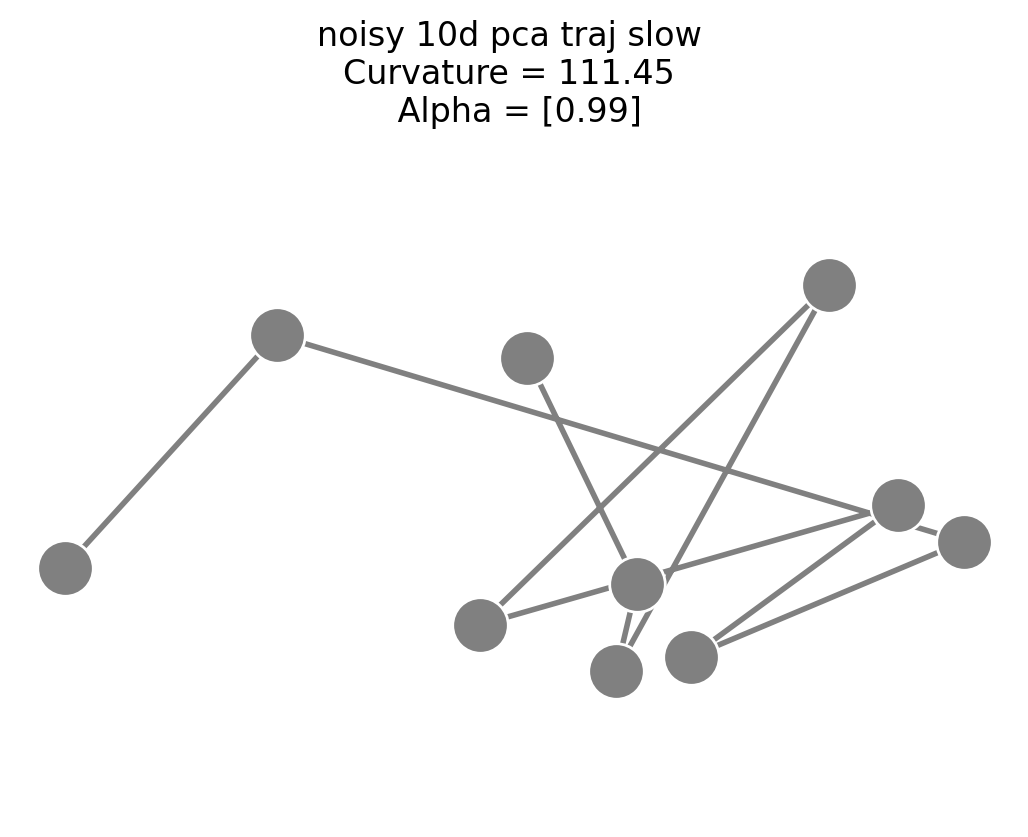

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))  
# noiseless data
# ax.plot(
#     noiseless_data_2d[:, 0], 
#     noiseless_data_2d[:, 1], 
#     '-o', 
#     markersize=20,                # slightly larger so edge is visible
#     linewidth=2, 
#     markerfacecolor='black',     # fill color
#     markeredgecolor='white',     # outline color
#     markeredgewidth=1,         # optional: control outline thickness
#     color="black"
# )
# noisy data
ax.plot(
    noisy_data_2d[:, 0], 
    noisy_data_2d[:, 1], 
    '-o', 
    markersize=20,                # slightly larger so edge is visible
    linewidth=2, 
    markerfacecolor='grey',     # fill color
    markeredgecolor='white',     # outline color
    markeredgewidth=1,         # optional: control outline thickness
    color="grey"
)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel("")
ax.set_ylabel("")
plt.title(f"noisy 10d pca traj slow \nCurvature = {curv:.2f} \n Alpha = {w_real}")
ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout(pad=0.2)
# plt.savefig("noisy_10d_pca_traj_slow.pdf", format='pdf', bbox_inches='tight')



##### Fig 2a. Check dimensionality doesn't play a role

In [3]:
# simulate AR(1) processes with different coefficients and see if the relationship preserves
ar_coeffs = np.linspace(0.1, 1, 10)
nBoots = 500
nT = 241
private_signal_std = 1.0 # latent private noise

nD = 10 # dimensionality
all_degs_10d = np.zeros((nBoots, len(ar_coeffs)))
for i in range(nBoots):
    for j, a in enumerate(ar_coeffs):
        private_signal_innov = np.random.randn(nD, nT) * private_signal_std
        ts = make_noiseless_arp(a, nT=nT, n_voxs=nD, private_signal_innov=private_signal_innov)
        deg = avg_pop_curvature(ts)
        all_degs_10d[i, j] = deg
print(all_degs_10d.shape)

nD = 100 # dimensionality
all_degs_1000d = np.zeros((nBoots, len(ar_coeffs)))
for i in range(nBoots):
    for j, a in enumerate(ar_coeffs):
        private_signal_innov = np.random.randn(nD, nT) * private_signal_std
        ts = make_noiseless_arp(a, nT=nT, n_voxs=nD, private_signal_innov=private_signal_innov)
        deg = avg_pop_curvature(ts)
        all_degs_1000d[i, j] = deg


(500, 10)


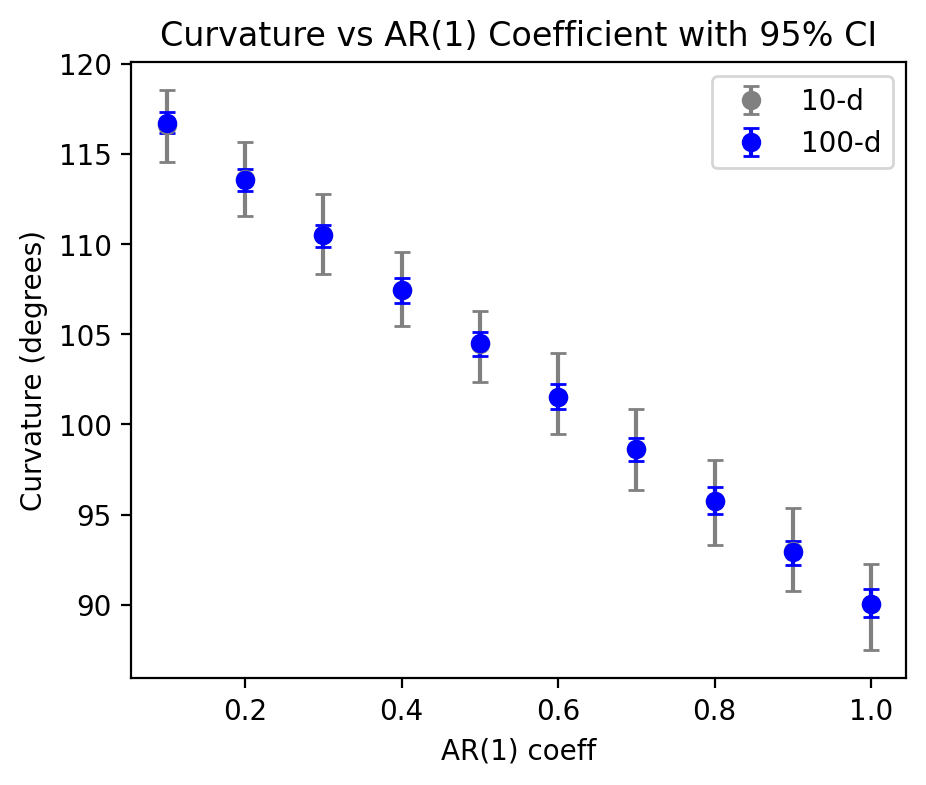

In [4]:
# Compute mean and 95% CI across bootstraps
# 10d
mean_curv_10d = all_degs_10d.mean(axis=0)             # shape: (len(alphas), nT)
lower_10d = np.percentile(all_degs_10d, 2.5, axis=0)   # shape: (len(alphas), nT)
upper_10d = np.percentile(all_degs_10d, 97.5, axis=0)
# 100d
mean_curv_1000d = all_degs_1000d.mean(axis=0)             # shape: (len(alphas), nT)
lower_1000d = np.percentile(all_degs_1000d, 2.5, axis=0)   # shape: (len(alphas), nT)
upper_1000d = np.percentile(all_degs_1000d, 97.5, axis=0)

# Compute error bars: distance from mean to lower/upper CI
yerr_10d = np.vstack([mean_curv_10d - lower_10d, upper_10d - mean_curv_10d])
yerr_1000d = np.vstack([mean_curv_1000d - lower_1000d, upper_1000d - mean_curv_1000d])

# Plot with error bars
fig = plt.figure()
ax = plt.gca()

ax.errorbar(ar_coeffs, mean_curv_10d, yerr=yerr_10d, fmt='o', capsize=3, color='gray', label='10-d')
ax.errorbar(ar_coeffs, mean_curv_1000d, yerr=yerr_1000d, fmt='o', capsize=3, color='blue', label='100-d')
ax.legend()
ax.set_xlabel("AR(1) coeff")
ax.set_ylabel("Curvature (degrees)")
ax.set_title("Curvature vs AR(1) Coefficient with 95% CI")
remove_clipping(ax)
fig.savefig("dimensionality-curvature-AR-CI.pdf", format='pdf')
plt.show()


$$ x_t = \alpha x_{t-1} + \epsilon_t$$

##### Fig 1e-2d. Demonstrate direct curvature measurements are not reliable 

In [26]:
ar_coeffs = np.linspace(0.1, 1, 10)
nBoots = 500
nT = 241
n_voxs = 100
nRuns = 10
corr = 0.1                          # shared signal
beta = 0.7                          # shared noise (lower beta = higher shared noise)
private_signal_std = 1.0            # latent private signal
added_meas_noise_std_high = 3.0     # measurement noise
added_meas_noise_std_low = 1.5

private_signal_inno_all = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT)) 
noiseless_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT))
noiseless_est_curv = np.zeros((nBoots, len(ar_coeffs))) 

noisy_timeseries = np.zeros((nBoots, len(ar_coeffs), nRuns, n_voxs, nT)) 
avg_noisy_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT)) 
noisy_est_curv = np.zeros((nBoots, len(ar_coeffs))) 

high_noisy_timeseries = np.zeros((nBoots, len(ar_coeffs), nRuns, n_voxs, nT)) 
high_noisy_est_curv = np.zeros((nBoots, len(ar_coeffs))) 
avg_high_noisy_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT)) 


for boot in range(nBoots):
    for a in range(len(ar_coeffs)):

        if nRuns == 1:
                beta_eff = 1.0

        else:
                beta_eff = beta
                
        
        # Noiseless (latent)
        private_signal_innov = np.random.randn(n_voxs, nT) * private_signal_std
        latent_ts = make_noiseless_arp(ar_coeffs[a], nT=nT, n_voxs=n_voxs, private_signal_innov=private_signal_innov)
        noiseless_timeseries[boot,a,:,:] = latent_ts

        # Noisy runs
        _, shared_signal_innov, _ = make_signal_innov(
            n_voxs=n_voxs,   
            nT=nT,
            private_signal_std=private_signal_std,
            corr=corr,
            beta=beta_eff,
        )

        for run in range(nRuns):
            # for each run, generate shared noise (shared across voxels, not runs)
            _, _, shared_noise_innov = make_signal_innov(
                n_voxs=n_voxs,
                nT=nT,
                private_signal_std=private_signal_std,
                corr=corr,
                beta=beta_eff,
            )
            # combine all the sources for innov term
            signal_innov = private_signal_innov + shared_signal_innov[None, :] + shared_noise_innov[None, :]
            # signal_innov = private_signal_innov + shared_signal_innov[None, :] + shared_noise_innov # no signal shared across voxels

            
            # add low noise
            noisy_ts = make_additive_noisy_arp(
                ar_coeff=ar_coeffs[a],
                nT=nT,
                n_voxs=n_voxs,
                signal_innov=signal_innov,
                measurement_noise_std=added_meas_noise_std_low,
            )
            noisy_timeseries[boot,a,run,:,:] = noisy_ts
            
            # add high noise
            high_noisy_ts = make_additive_noisy_arp(
                ar_coeff=ar_coeffs[a],
                nT=nT,
                n_voxs=n_voxs,
                signal_innov=signal_innov,
                measurement_noise_std=added_meas_noise_std_high,
            )
            high_noisy_timeseries[boot,a,run,:,:] = high_noisy_ts

        avg_noiseless_ts = latent_ts
        # run averages
        avg_noisy_ts = np.mean(noisy_timeseries[boot,a],axis=0) 
        avg_noisy_timeseries[boot,a,:,:] = avg_noisy_ts
        avg_high_noisy_ts = np.mean(high_noisy_timeseries[boot,a],axis=0)
        avg_high_noisy_timeseries[boot,a,:,:] = avg_high_noisy_ts

        noiseless_est_curv[boot, a] = avg_pop_curvature(avg_noiseless_ts)
        noisy_est_curv[boot, a] = avg_pop_curvature(avg_noisy_ts)
        high_noisy_est_curv[boot, a] = avg_pop_curvature(avg_high_noisy_ts)




##### Visualize some trajectories

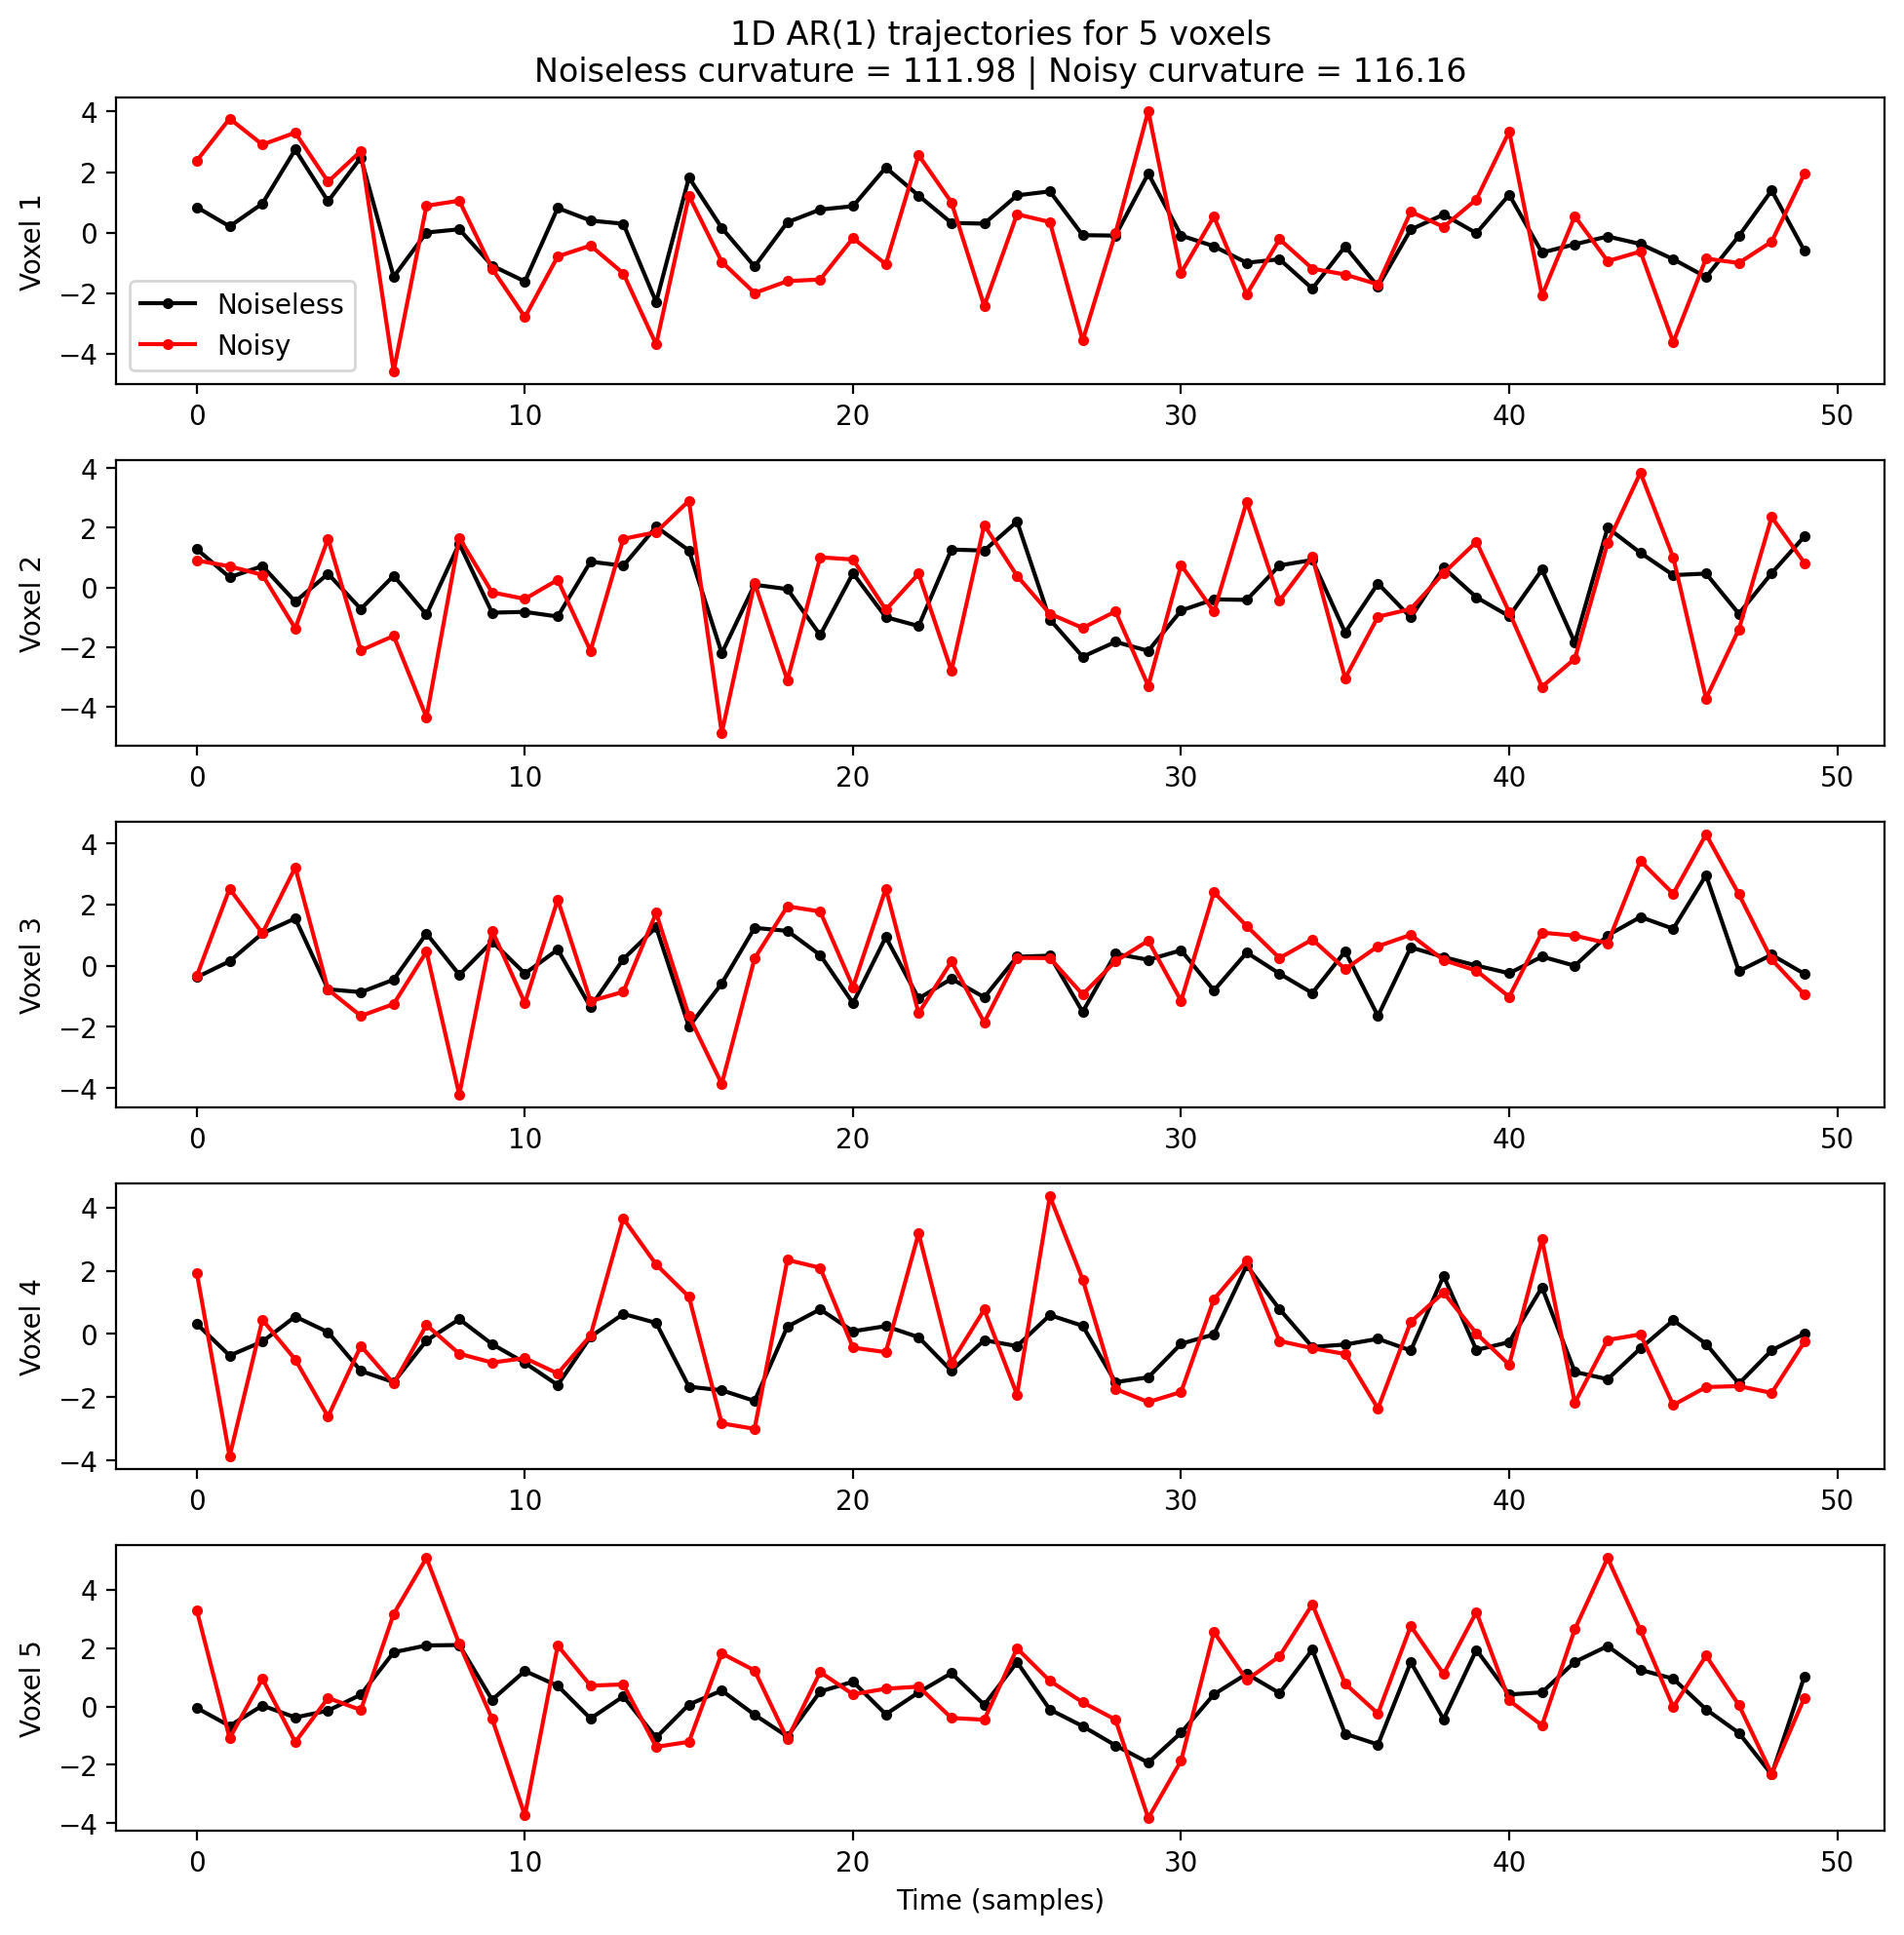

In [36]:
# 1D 
noiseless_data = noiseless_timeseries[0, 1]      # shape: (nBoots, len(ar_coeffs), n_voxs, nT)
noisy_data     = noisy_timeseries[0, 1, 0]       # shape: (nBoots, len(ar_coeffs), nRuns, n_voxs, nT)

noiseless_curv = avg_pop_curvature(noiseless_data)
noisy_curv     = avg_pop_curvature(noisy_data)

# number of voxels to plot
n_vox_to_plot = 5

# number of timepoints
T = 50

t = np.arange(T)

plt.figure(figsize=(10, 10))

for i in range(n_vox_to_plot):

    nl = noiseless_data[i, :T]
    nz = noisy_data[i, :T]

    ax = plt.subplot(n_vox_to_plot, 1, i + 1)

    ax.plot(t, nl, '-o', color='black', markersize=3, label='Noiseless')
    ax.plot(t, nz, '-o', color='red', markersize=3, label='Noisy')

    ax.set_ylabel(f"Voxel {i+1}")
    
    if i == 0:
        ax.set_title(f"1D AR(1) trajectories for 5 voxels\n"
                     f"Noiseless curvature = {noiseless_curv:.2f} | "
                     f"Noisy curvature = {noisy_curv:.2f}")
    
    if i == n_vox_to_plot - 1:
        ax.set_xlabel("Time (samples)")

    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()


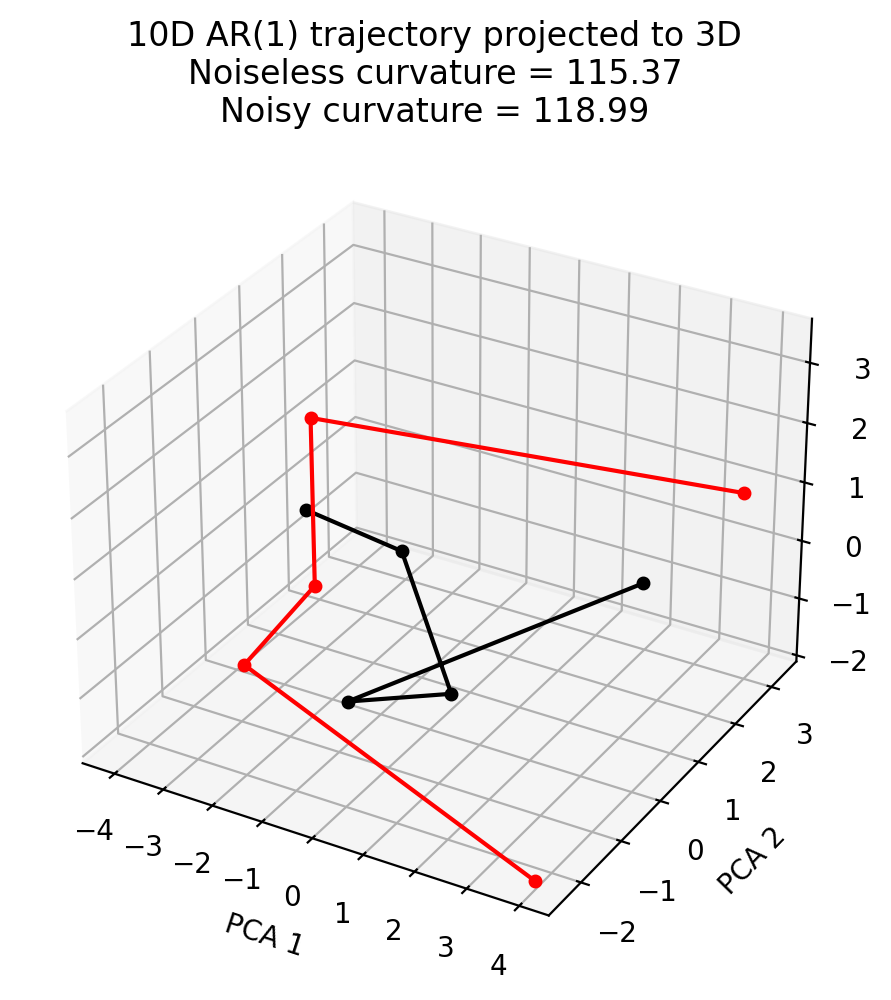

In [ ]:
# 3D, PCA
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

noiseless_data = noiseless_timeseries[0,0]   # shape: (n_voxs, nT)
noisy_data = noisy_timeseries[0,0,0]

noiseless_curv = avg_pop_curvature(noiseless_data)
noisy_curv = avg_pop_curvature(noisy_data)

# --- PCA: use timepoints as samples ---
noiseless_data_T = noiseless_data.T[:5,:]
noisy_data_T = noisy_data.T[:5,:]                # shape: (nT, n_voxs)

pca = PCA(n_components=3)
noiseless_data_3d = pca.fit_transform(noiseless_data_T)  # shape: (nT, 3)
noisy_data_3d = pca.fit_transform(noisy_data_T)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')   
ax.plot(noiseless_data_3d[:, 0], noiseless_data_3d[:, 1], noiseless_data_3d[:, 2],
        '-o', markersize=4, color='black')
ax.plot(noisy_data_3d[:, 0], noisy_data_3d[:, 1], noisy_data_3d[:, 2],
        '-o', markersize=4, color='red')
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title(f"10D AR(1) trajectory projected to 3D\nNoiseless curvature = {noiseless_curv:.2f}\nNoisy curvature = {noisy_curv:.2f}")

plt.tight_layout()
plt.show()



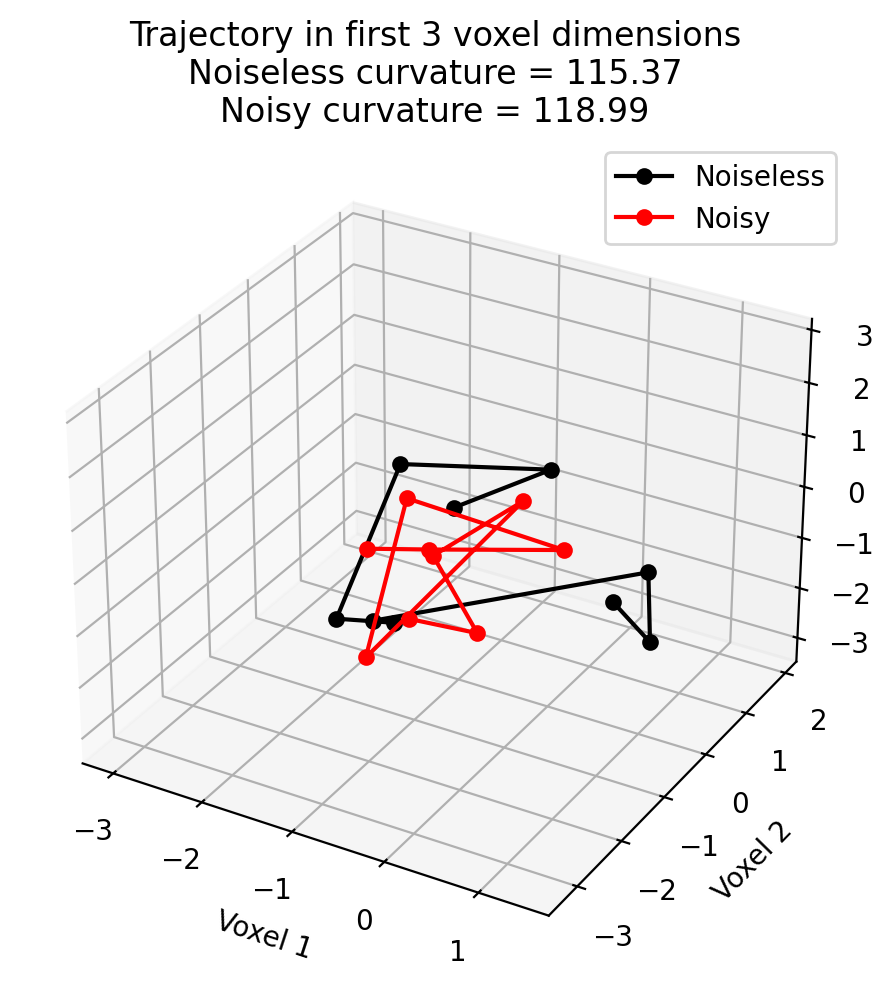

In [20]:
# 3D, first 3 dimensions
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# --- Extract data ---
noiseless_data = noiseless_timeseries[0, 0]   # shape: (n_voxs, nT)
noisy_data     = noisy_timeseries[0, 0, 0]    # shape: (n_voxs, nT)

noiseless_curv = avg_pop_curvature(noiseless_data)
noisy_curv = avg_pop_curvature(noisy_data)

# --- Use the first 3 voxel dimensions, and first 9 timepoints ---
nl = noiseless_data[:3, :9]   # shape: (3, 9)
nz = noisy_data[:3, :9]       # shape: (3, 9)

x_nl, y_nl, z_nl = nl          # unpack voxel dims
x_nz, y_nz, z_nz = nz

# --- Plot ---
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_nl, y_nl, z_nl, '-o', markersize=5, color='black', label='Noiseless')
ax.plot(x_nz, y_nz, z_nz, '-o', markersize=5, color='red', label='Noisy')

ax.set_xlabel("Voxel 1")
ax.set_ylabel("Voxel 2")
ax.set_zlabel("Voxel 3")
ax.set_title(f"Trajectory in first 3 voxel dimensions\nNoiseless curvature = {noiseless_curv:.2f}\nNoisy curvature = {noisy_curv:.2f}")

ax.legend()
plt.tight_layout()
plt.show()


##### AR(1) - curvature estimates for noiseless vs. noisy series
- this demonstrates noise makes the relationship between AR(1) and curvature breaks down

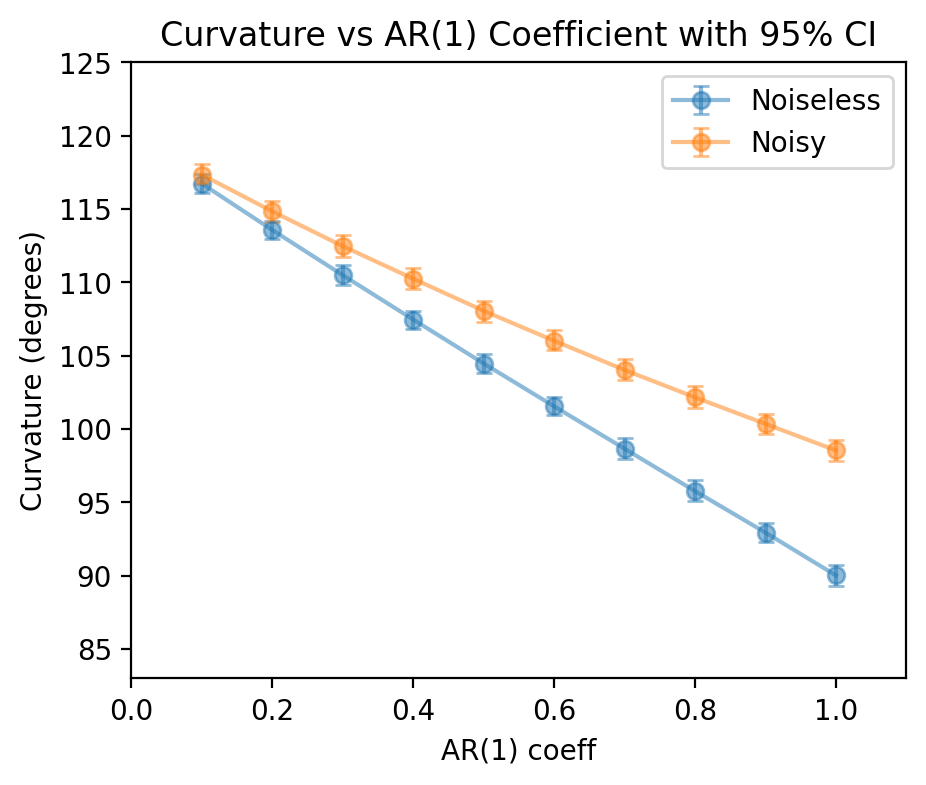

Noiseless mean curvature: [116.73367772 113.5749876  110.49412039 107.46982571 104.47294377
 101.55278487  98.66015304  95.77174086  92.94393498  90.0238717 ] shape:  (10,)
Noisy mean curvature: [117.34289459 114.84386301 112.47436436 110.25098927 108.06231456
 106.02341552 104.02904525 102.16574985 100.35545985  98.54931289] shape:  (10,)


In [27]:
# Compute mean and 95% CI across bootstraps
noiseless_mean_curv = noiseless_est_curv.mean(axis=0)  # average across bootstraps           
noiseless_lower = np.percentile(noiseless_est_curv, 2.5, axis=0)   
noiseless_upper = np.percentile(noiseless_est_curv, 97.5, axis=0) # shape: len(ar_coeffs)

noisy_mean_curv = noisy_est_curv.mean(axis=0)             
noisy_lower = np.percentile(noisy_est_curv, 2.5, axis=0)   
noisy_upper = np.percentile(noisy_est_curv, 97.5, axis=0) # shape: len(ar_coeffs)

# Compute error bars: distance from mean to lower/upper CI
noiseless_yerr = np.vstack([noiseless_mean_curv - noiseless_lower, noiseless_upper - noiseless_mean_curv])
noisy_yerr = np.vstack([noisy_mean_curv - noisy_lower, noisy_upper - noisy_mean_curv])

# Plot with error bars
plt.errorbar(ar_coeffs, noiseless_mean_curv, yerr=noiseless_yerr, fmt='o-', capsize=3, label='Noiseless',alpha = 0.5)
plt.errorbar(ar_coeffs, noisy_mean_curv, yerr=noisy_yerr, fmt='o-', capsize=3, label='Noisy', alpha = 0.5)

plt.xlim(0, 1.1)
plt.ylim(83, 125)
plt.xlabel("AR(1) coeff")
plt.ylabel("Curvature (degrees)")
plt.title("Curvature vs AR(1) Coefficient with 95% CI")
plt.legend()
plt.show()

print("Noiseless mean curvature:", noiseless_mean_curv, "shape: ", noiseless_mean_curv.shape) # direct noiseless/ground truth 
print("Noisy mean curvature:", noisy_mean_curv, "shape: ", noisy_mean_curv.shape) # direct white noise 


Plotting with specified format for illustrator (pdf)

In [26]:
fig, ax = plt.subplots(figsize=(5, 4))  

ax.errorbar(
    ar_coeffs, noiseless_mean_curv, yerr=noiseless_yerr,
    fmt='o-', markersize=15, linewidth=2, elinewidth=2, capsize=0,
    label='Noiseless', alpha=1, color='black'
)
ax.errorbar(
    ar_coeffs, noisy_mean_curv, yerr=noisy_yerr,
    fmt='o-', markersize=15, linewidth=2, elinewidth=2, capsize=0,
    label='Noisy', alpha=1, color=(0.5, 0.5, 0.5)
)

ax.set_xlim(0, 1.1)
ax.set_ylim(83, 125)
ax.set_yticks([90, 120])
ax.set_xlabel("AR(1) coeff", fontsize=4, labelpad=1)
ax.set_ylabel("Curvature (°)", fontsize=4, labelpad=1)
ax.tick_params(axis='both', labelsize=3, pad=1)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout(pad=0.1)

plt.savefig("single_run_curv_AR.pdf", format='pdf', bbox_inches='tight') 
# plt.savefig("10_run_curv_AR.pdf", format='pdf', bbox_inches='tight') 

plt.close()

Plotting ground truth curvature vs. estimated curvature

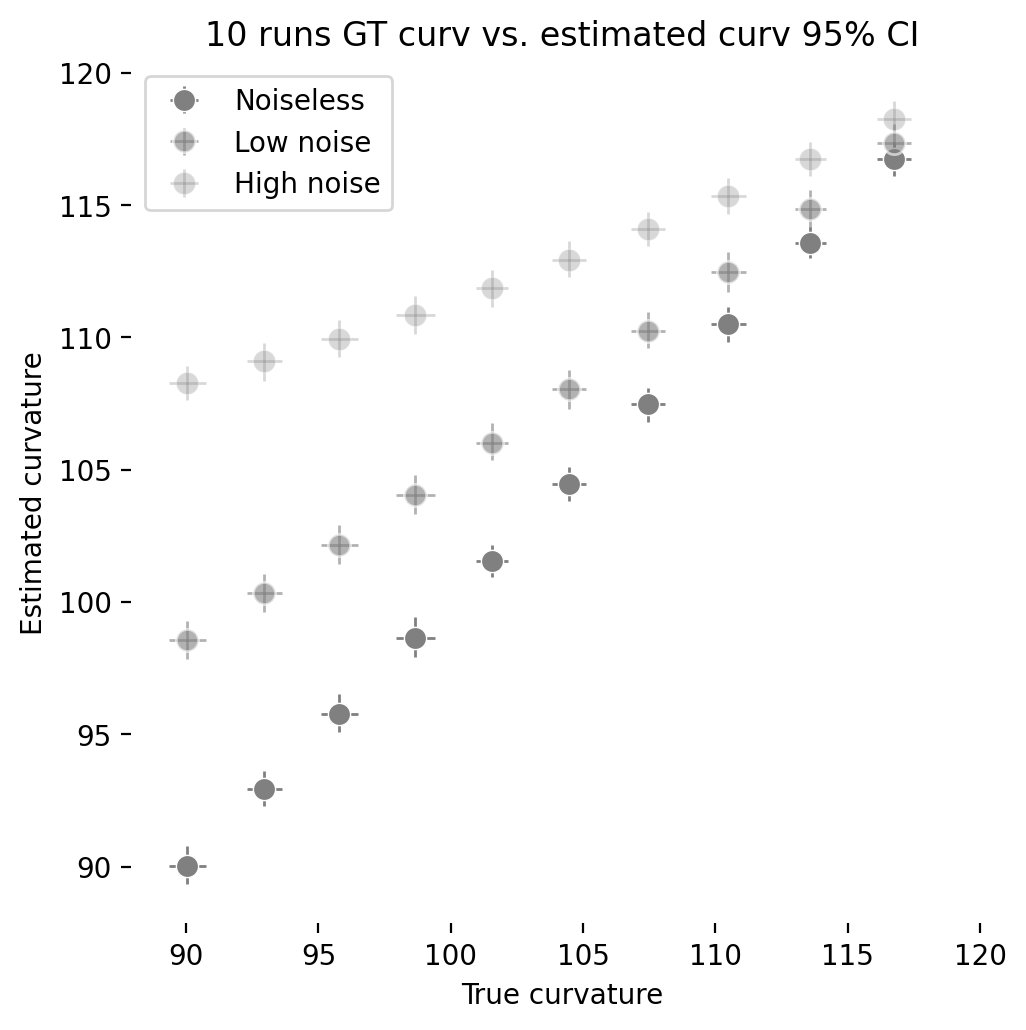

In [28]:
# noiseless_mean_curv = noiseless_est_curv.mean(axis=0)
# noisy_mean_curv     = noisy_est_curv.mean(axis=0)
# high_noisy_mean_curv = high_noisy_est_curv.mean(axis=0)

def bootstrap_ci(data):
    lower = np.percentile(data, 2.5, axis=0)
    upper = np.percentile(data, 97.5, axis=0)
    mean  = data.mean(axis=0)
    return mean, [mean - lower, upper - mean]

noiseless_mean, noiseless_ci = bootstrap_ci(noiseless_est_curv)
noisy_mean, noisy_ci = bootstrap_ci(noisy_est_curv)
high_noisy_mean, high_noisy_ci = bootstrap_ci(high_noisy_est_curv)

# ---- Plot ----
axis_stroke    = 0.5  * 72    # 36 pt
axis_height    = 0.85 * 72    # 61.2 pt
fig, ax = plt.subplots(figsize=(5, 5))

# NOISELESS (darkest gray)
ax.errorbar(
    noiseless_mean,
    noiseless_mean,
    xerr=noiseless_ci,
    yerr=noiseless_ci,
    fmt='o',
    markersize=8,
    markerfacecolor='gray',
    markeredgecolor='white',
    markeredgewidth=0.5,
    linewidth=1,
    color='gray',
    alpha=1.0,
    label="Noiseless"
)

# LOW NOISE (medium opacity)
ax.errorbar(
    noiseless_mean,
    noisy_mean,
    xerr=noiseless_ci,
    yerr=noisy_ci,
    fmt='o',
    markersize=8,
    markerfacecolor='gray',
    markeredgecolor='white',
    markeredgewidth=1,
    linewidth=1,
    color='gray',
    alpha=0.6,
    label="Low noise"
)

# HIGH NOISE (lightest opacity)
ax.errorbar(
    noiseless_mean,
    high_noisy_mean,
    xerr=noiseless_ci,
    yerr=high_noisy_ci,
    fmt='o',
    markersize=8,
    markerfacecolor='gray',
    markeredgecolor='white',
    markeredgewidth=0.5,
    linewidth=1,
    color='gray',
    alpha=0.3,
    label="High noise"
)

# ---- Axes ----
ax.set_xlabel("True curvature")
ax.set_ylabel("Estimated curvature")

# Square and equal limits
ax.set_aspect('equal', adjustable='datalim')
ax.axis('square')

# ---- Spines thickness ----
for spine in ax.spines.values():
    spine.set_visible(False)

# Emphasize vertical spines (your requested axis_height)
ax.spines['left'].set_linewidth(axis_height)
ax.spines['right'].set_linewidth(axis_height)

ax.legend()

plt.tight_layout(pad=0.3)
# ax.set_title("one run GT curv vs. estimated curv 95% CI")
# plt.savefig("one run GT curv vs. estimated curv 95% CI.pdf", format='pdf')

ax.set_title("10 runs GT curv vs. estimated curv 95% CI")
plt.savefig("10 runs GT curv vs. estimated curv 95% CI.pdf", format='pdf')

plt.show()


##### Fig 2a-b Estimate AR(1) coefficient as an indirect proxy for curvature 

1) fit AR(1) model on single voxel data

In [28]:
# recover AR coefficients (from 10-D data - approximates averaging across 10 runs for a single voxel)
noiseless_ar_coeff = np.zeros((nBoots,len(ar_coeffs),n_voxs))  
noisy_ar_coeff = np.zeros((nBoots,len(ar_coeffs),n_voxs))  
vox_avg_noiseless_ar_coeff = np.zeros((nBoots,len(ar_coeffs)))  
vox_avg_noisy_ar_coeff = np.zeros((nBoots,len(ar_coeffs)))  
rec_noiseless_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT))
rec_noisy_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT))
rec_noiseless_est_curv = np.zeros((nBoots, len(ar_coeffs)))
rec_noisy_est_curv = np.zeros((nBoots, len(ar_coeffs)))

avg_noiseless_timeseries = noiseless_timeseries


for boot in range(nBoots):
        for a in range(len(ar_coeffs)):
        # --- noiseless ---
                for v in range(n_voxs):
                        zs_avg_noiseless_ts = zs(avg_noiseless_timeseries[boot,a,v])
                        noiseless_ar1_model = sm.tsa.AutoReg(zs_avg_noiseless_ts, lags=1).fit()
                        noiseless_ar_coeff[boot, a, v] = noiseless_ar1_model.params[1]
                a_noiseless = np.mean(noiseless_ar_coeff[boot,a])
                vox_avg_noiseless_ar_coeff[boot,a] = a_noiseless
                # use recovered AR coeff to simulate new timeseries 
                private_signal_innov = np.random.randn(n_voxs, nT) * private_signal_std
                rec_noiseless_timeseries[boot, a, :, :] = make_noiseless_arp(ar_coeff=a_noiseless, 
                                                                               nT=nT, 
                                                                               n_voxs=n_voxs,
                                                                               private_signal_innov=private_signal_innov)
                # calculate curvature (Avg GT)
                rec_noiseless_est_curv[boot, a] = avg_pop_curvature(rec_noiseless_timeseries[boot, a, :, :])

        # --- noisy (high) ---
                for v in range(n_voxs):
                                zs_avg_noisy_ts = zs(avg_noisy_timeseries[boot,a,v])
                                noisy_ar1_model = sm.tsa.AutoReg(zs_avg_noisy_ts, lags=1).fit()
                                noisy_ar_coeff[boot, a, v] = noisy_ar1_model.params[1]
                a_noisy = np.mean(noisy_ar_coeff[boot,a])
                vox_avg_noisy_ar_coeff[boot,a] = a_noisy
                # use recovered AR coeff to simulate new timeseries 
                rec_noisy_timeseries[boot, a, :, :] = make_noiseless_arp(ar_coeff=a_noisy, 
                                                                           nT=nT, 
                                                                           n_voxs=n_voxs,
                                                                           private_signal_innov=private_signal_innov)
                # calculate curvature 
                rec_noisy_est_curv[boot, a] = avg_pop_curvature(rec_noisy_timeseries[boot, a, :, :])

# ------------- plotting -------------
# Compute means
noiseless_mean_ar = np.mean(vox_avg_noiseless_ar_coeff,axis=0)
noisy_mean_ar = np.mean(vox_avg_noisy_ar_coeff,axis=0)

# Compute 95% bootstrap percentile confidence intervals (asymmetric)
noiseless_lower = np.percentile(vox_avg_noiseless_ar_coeff, 2.5, axis=0)
noiseless_upper = np.percentile(vox_avg_noiseless_ar_coeff, 97.5, axis=0)
noiseless_ci = [noiseless_mean_ar - noiseless_lower, noiseless_upper - noiseless_mean_ar]
noisy_lower = np.percentile(vox_avg_noisy_ar_coeff, 2.5, axis=0)
noisy_upper = np.percentile(vox_avg_noisy_ar_coeff, 97.5, axis=0)
noisy_ci = [noisy_mean_ar - noisy_lower, noisy_upper - noisy_mean_ar]

# Plot
plt.errorbar(ar_coeffs, noiseless_mean_ar, yerr=noiseless_ci, fmt='o', label='Noiseless', alpha=1, capsize=3, color='gray')
plt.errorbar(ar_coeffs, noisy_mean_ar, yerr=noisy_ci, fmt='o', label='Noisy', alpha=0.5, capsize=3, color='blue')
plt.plot(ar_coeffs, ar_coeffs, 'k--', linewidth=1, alpha=0.5)  # y = x reference line
plt.xlabel("True AR(1) coeff")      
plt.ylabel("Estimated AR(1) coeff")
plt.legend()

plt.title("one run GT AR(1) coeff vs. estimated AR(1) coeff 95%CI")
plt.savefig("one_run_GTar1_ar1.pdf", format='pdf', bbox_inches='tight')

# plt.title("10 runs GT AR(1) coeff vs. estimated AR(1) coeff 95%CI")
# plt.savefig("10_runs_GTar1_ar1.pdf", format='pdf', bbox_inches='tight')


        

KeyboardInterrupt: 

2) fit AR(1) model on voxel averaged data

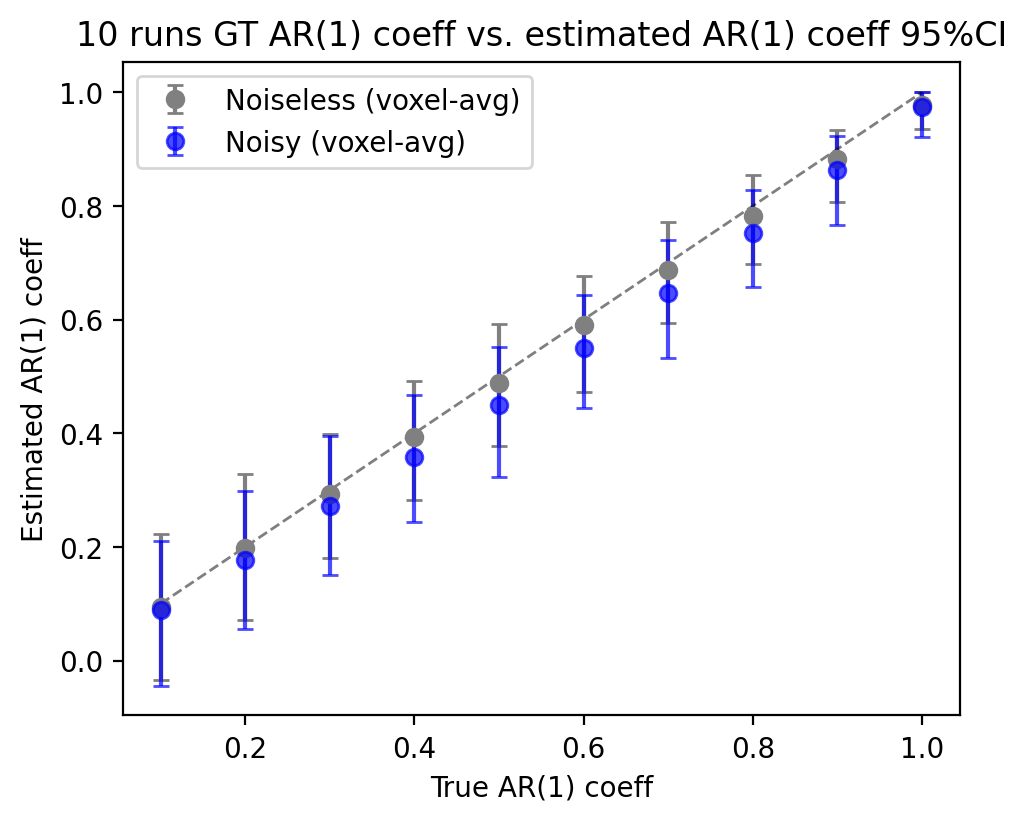

In [29]:
# average across runs for noisy data 
avg_noisy_timeseries = noisy_timeseries.mean(axis=2)   # (nBoots, n_alphas, n_voxs, nT)

rec_noiseless_ar_coeff  = np.zeros((nBoots, len(ar_coeffs)))
rec_noisy_ar_coeff      = np.zeros((nBoots, len(ar_coeffs)))
rec_noiseless_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT))
rec_noisy_timeseries     = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT))
rec_noiseless_est_curv   = np.zeros((nBoots, len(ar_coeffs)))
rec_noisy_est_curv       = np.zeros((nBoots, len(ar_coeffs)))

for boot in range(nBoots):
    for a_idx in range(len(ar_coeffs)):

        # --- noiseless ---
        mean_noiseless_ts = noiseless_timeseries[boot, a_idx].mean(axis=0)  # (nT,)
        zs_noiseless_ts   = zs(mean_noiseless_ts)
        noiseless_model   = sm.tsa.AutoReg(zs_noiseless_ts, lags=1).fit()
        a_noiseless       = noiseless_model.params[1]  # AR(1) coefficient
        rec_noiseless_ar_coeff[boot, a_idx] = a_noiseless

        # simulate new timeseries using recovered coeff
        private_signal_innov = np.random.randn(n_voxs, nT) * private_signal_std
        rec_noiseless_timeseries[boot, a_idx] = make_noiseless_arp(
            ar_coeff=a_noiseless,
            nT=nT,
            n_voxs=n_voxs,
            private_signal_innov=private_signal_innov,
        )

        # curvature of reconstructed noiseless population
        rec_noiseless_est_curv[boot, a_idx] = avg_pop_curvature(
            rec_noiseless_timeseries[boot, a_idx]
        )

        # --- noisy ---
        mean_noisy_ts = avg_high_noisy_timeseries[boot, a_idx].mean(axis=0)  # (nT,)
        zs_noisy_ts   = zs(mean_noisy_ts)
        noisy_model   = sm.tsa.AutoReg(zs_noisy_ts, lags=1).fit()
        a_noisy       = noisy_model.params[1]
        rec_noisy_ar_coeff[boot, a_idx] = a_noisy

        # use SAME innovations as above if you want matched noise structure
        rec_noisy_timeseries[boot, a_idx] = make_noiseless_arp(
            ar_coeff=a_noisy,
            nT=nT,
            n_voxs=n_voxs,
            private_signal_innov=private_signal_innov,
        )

        rec_noisy_est_curv[boot, a_idx] = avg_pop_curvature(
            rec_noisy_timeseries[boot, a_idx]
        )

# Compute means across boots
noiseless_mean_ar = np.mean(rec_noiseless_ar_coeff, axis=0)   # shape: (len(ar_coeffs),)
noisy_mean_ar     = np.mean(rec_noisy_ar_coeff, axis=0)

# Compute 95% bootstrap percentile confidence intervals (asymmetric)
noiseless_lower = np.percentile(rec_noiseless_ar_coeff, 2.5, axis=0)
noiseless_upper = np.percentile(rec_noiseless_ar_coeff, 97.5, axis=0)
noiseless_ci = [noiseless_mean_ar - noiseless_lower,
                noiseless_upper - noiseless_mean_ar]

noisy_lower = np.percentile(rec_noisy_ar_coeff, 2.5, axis=0)
noisy_upper = np.percentile(rec_noisy_ar_coeff, 97.5, axis=0)
noisy_ci = [noisy_mean_ar - noisy_lower,
            noisy_upper - noisy_mean_ar]

# Plot
plt.figure(figsize=(5, 4))
plt.errorbar(ar_coeffs, noiseless_mean_ar, yerr=noiseless_ci,
             fmt='o', label='Noiseless (voxel-avg)', alpha=1,
             capsize=3, color='gray')
plt.errorbar(ar_coeffs, noisy_mean_ar, yerr=noisy_ci,
             fmt='o', label='Noisy (voxel-avg)', alpha=0.7,
             capsize=3, color='blue')

# y = x reference line
plt.plot(ar_coeffs, ar_coeffs, 'k--', linewidth=1, alpha=0.5)

plt.xlabel("True AR(1) coeff")
plt.ylabel("Estimated AR(1) coeff")
plt.legend()
plt.tight_layout()

# plt.title("one run GT AR(1) coeff vs. estimated AR(1) coeff 95%CI")
# plt.savefig("one_run_GTar1_ar1.pdf", format='pdf', bbox_inches='tight')

plt.title("10 runs GT AR(1) coeff vs. estimated AR(1) coeff 95%CI")
plt.savefig("10_runs_GTar1_ar1.pdf", format='pdf', bbox_inches='tight')



Calculate the curvature estimation errors for different methods

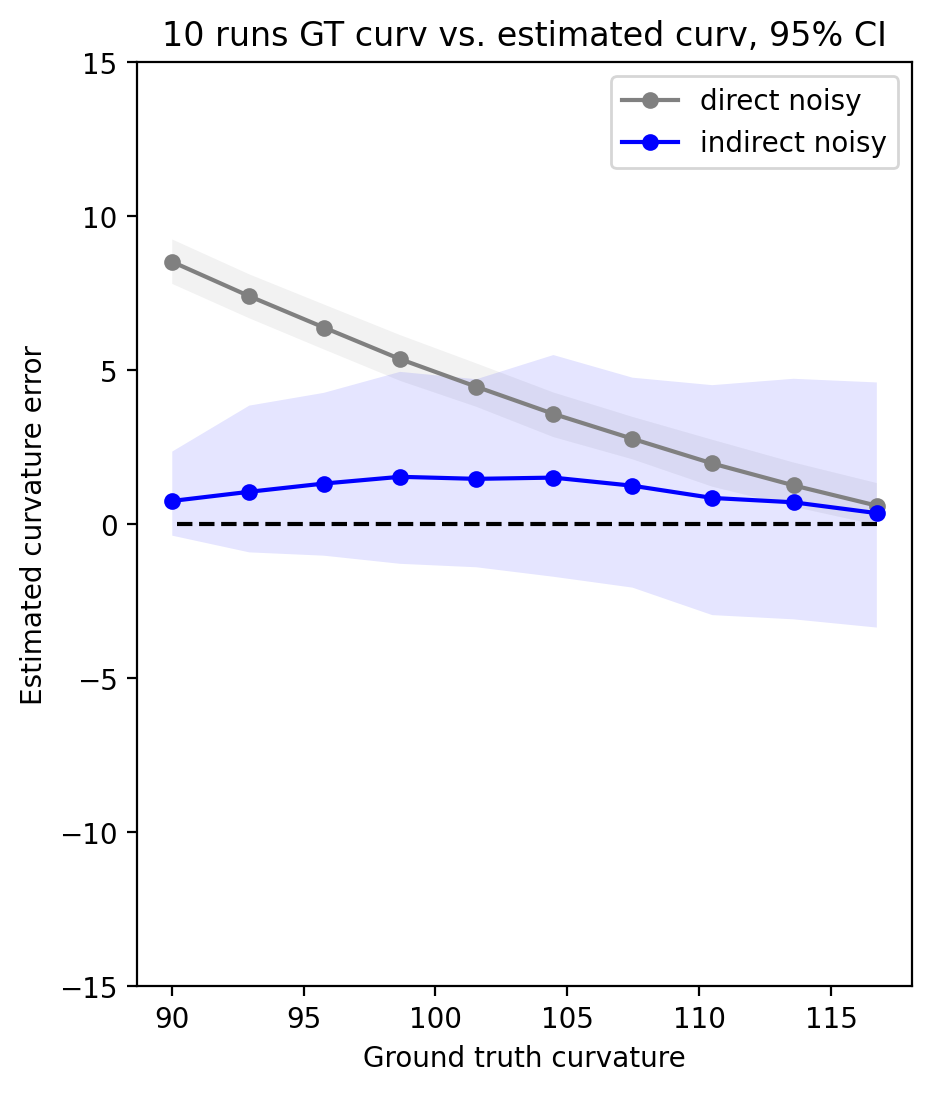

In [31]:
# direct noiseless
dir_noiseless = noiseless_mean_curv - noiseless_mean_curv
# direct noisy
dir_noisy_est = noisy_est_curv - noiseless_mean_curv
dir_noisy_mean = dir_noisy_est.mean(axis=0)
# Compute 95% bootstrap percentile confidence intervals (asymmetric)
dir_noisy_lower = np.percentile(dir_noisy_est, 2.5, axis=0)
dir_noisy_upper = np.percentile(dir_noisy_est, 97.5, axis=0)
ci = [dir_noisy_mean - dir_noisy_lower, dir_noisy_upper - dir_noisy_mean]

# indirect noiseless
indirect_noiseless_est = rec_noiseless_est_curv - noiseless_mean_curv
ind_noiseless_mean = indirect_noiseless_est.mean(axis=0)
ind_noiseless_lower = np.percentile(indirect_noiseless_est, 2.5, axis=0)
ind_noiseless_upper = np.percentile(indirect_noiseless_est, 97.5, axis=0)
ind_noiseless_ci = [ind_noiseless_mean - ind_noiseless_lower,
                    ind_noiseless_upper - ind_noiseless_mean]

# Indirect noisy 
indirect_noisy_est = rec_noisy_est_curv - noiseless_mean_curv
ind_noisy_mean = indirect_noisy_est.mean(axis=0)
ind_noisy_lower = np.percentile(indirect_noisy_est, 2.5, axis=0)
ind_noisy_upper = np.percentile(indirect_noisy_est, 97.5, axis=0)
ind_noisy_ci = [ind_noisy_mean - ind_noisy_lower,
                ind_noisy_upper - ind_noisy_mean]

# plotting with error bars 
plt.figure(figsize=(5, 6))

# --- Ground truth line ---
# plt.plot(noiseless_mean_curv, dir_noiseless, 'o-', alpha=1, color='black', markersize=5)
plt.plot(noiseless_mean_curv, dir_noiseless,'--', color='black')

# --- Direct noisy ---
plt.plot(noiseless_mean_curv, dir_noisy_mean, 'o-', alpha=1, label='direct noisy', color='grey', markersize=5)
plt.fill_between(
    noiseless_mean_curv,
    dir_noisy_mean - ci[0],
    dir_noisy_mean + ci[1],
    color='grey', alpha=0.1,
    edgecolor='none',
    linewidth=0
)

# --- Indirect noiseless ---
# plt.plot(noiseless_mean_curv, ind_noiseless_mean, 'o-', alpha=1, label='indirect noiseless', color='blue', markersize=5)
# plt.fill_between(
#     noiseless_mean_curv,
#     ind_noiseless_mean - ind_noiseless_ci[0],
#     ind_noiseless_mean + ind_noiseless_ci[1],
#     color='blue', alpha=0.1,
#     edgecolor='none', linewidth=0
# )

# --- Indirect noisy ---
plt.plot(noiseless_mean_curv, ind_noisy_mean, 'o-', alpha=1, label='indirect noisy', color='blue', markersize=5)
plt.fill_between(
    noiseless_mean_curv,
    ind_noisy_mean - ind_noisy_ci[0],
    ind_noisy_mean + ind_noisy_ci[1],
    color='blue', alpha=0.1,
    edgecolor='none',
    linewidth=0
)

plt.legend()
plt.ylim(-15, 15)
plt.yticks(np.arange(-15, 16, 5))
plt.xlabel("Ground truth curvature")
plt.ylabel("Estimated curvature error")

# plt.title("one run GT curv vs. estimated curv, 95% CI")
# plt.savefig("one_run_curv_est_error.pdf", format='pdf', bbox_inches='tight')
plt.title("10 runs GT curv vs. estimated curv, 95% CI")
plt.savefig("10_runs_curv_est_error.pdf", format='pdf', bbox_inches='tight')

plt.show()


Plotting with specified format for illustrator (pdf)

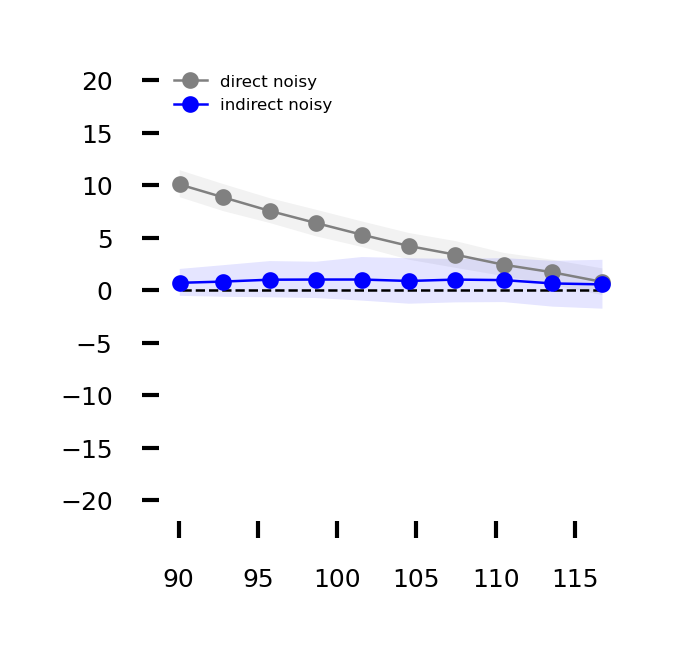

In [ ]:
figsize_inches = (1, 1)

marker_size     = 1      
marker_edge     = 0.1     
line_width      = 0.3     
font_size       = 4       
alpha_noiseless = 1.0
alpha_low       = 0.6
alpha_high      = 0.3

fig, ax = plt.subplots(figsize=figsize_inches, dpi=300)

# --- Ground truth line ---
# plt.plot(noiseless_mean_curv, dir_noiseless, 'o-', alpha=1, color='black', markersize=5)
plt.plot(noiseless_mean_curv, dir_noiseless,'--', color='black', linewidth=line_width)

# --- Direct noisy ---
plt.plot(noiseless_mean_curv, dir_noisy_mean, 'o-', alpha=1, label='direct noisy', color='grey', markersize=marker_size, linewidth=line_width)
plt.fill_between(
    noiseless_mean_curv,
    dir_noisy_mean - ci[0],
    dir_noisy_mean + ci[1],
    color='grey', alpha=0.1,
    edgecolor='none',
    linewidth=0
)

# --- Indirect noiseless ---
# plt.plot(noiseless_mean_curv, ind_noiseless_mean, 'o-', alpha=1, label='indirect noiseless', color='blue', markersize=5)
# plt.fill_between(
#     noiseless_mean_curv,
#     ind_noiseless_mean - ind_noiseless_ci[0],
#     ind_noiseless_mean + ind_noiseless_ci[1],
#     color='blue', alpha=0.1
# )

# --- Indirect noisy ---
plt.plot(noiseless_mean_curv, ind_noisy_mean, 'o-', alpha=1, label='indirect noisy', color='blue', markersize=marker_size, linewidth=line_width)
plt.fill_between(
    noiseless_mean_curv,
    ind_noisy_mean - ind_noisy_ci[0],
    ind_noisy_mean + ind_noisy_ci[1],
    color='blue', alpha=0.1,
    edgecolor='none',
    linewidth=0
)

ax.legend(loc='upper left', fontsize=2, frameon=False)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='both',
               which='both',
               labelsize=3,   # font size of tick labels
               length=2,      # length of tick marks
               width=0.5)       # line width of tick marksax.set_xlim(-0.1, 1.1)

plt.ylim(-22, 22)
# plt.xlabel("Ground truth curvature")
# plt.ylabel("Estimated curvature error")
plt.savefig("one_run_curv_est_error_tiny.pdf", format='pdf', bbox_inches='tight')
# plt.savefig("10_runs_curv_est_error_tiny.pdf", format='pdf', bbox_inches='tight')

plt.show()
